In [297]:
#!/usr/bin/python

import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import grid_search
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

%matplotlib inline

In [298]:
### Task 1: Select what features to use

### Initially, select them all for passing to SelectKBest
features_list = ['poi','salary','to_messages','deferral_payments',
                  'total_payments','exercised_stock_options',
                  'bonus','restricted_stock','shared_receipt_with_poi',
                  'restricted_stock_deferred','total_stock_value',
                  'expenses','loan_advances','from_messages',
                  'other','from_this_person_to_poi',
                  'director_fees', 'deferred_income','long_term_incentive',
                  'from_poi_to_this_person']


### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [299]:
### Task 2: Remove outliers
### Remove the TOTAL entry, cause we know it's wrong
del data_dict['TOTAL']
del data_dict['THE TRAVEL AGENCY IN THE PARK']

In [245]:
### Extract features and labels from dataset and have a closer look
data = featureFormat(data_dict, features_list, remove_NaN = True, remove_all_zeroes = True, sort_keys = False)
labels, features = targetFeatureSplit(data)

In [302]:
scaler = MinMaxScaler()
pca = PCA()
skb = SelectKBest()
clf_dt = tree.DecisionTreeClassifier()


pipe = Pipeline(steps=[("Scaler",scaler),("PCA",pca),("SKB", skb), ("DecisionTreeClassifier", clf_dt)])

scaler_params = {"Scaler__feature_range": [(0,1)]}

pca_params = {"PCA__n_components": [10,12,15]}

kbest_params = {"SKB__k": range(4,7)}

dt_params = {"DecisionTreeClassifier__min_samples_leaf": [2, 3,4],
             "DecisionTreeClassifier__min_samples_split": [7, 8,9],
             "DecisionTreeClassifier__min_weight_fraction_leaf": [0,0.05, 0.1],
             "DecisionTreeClassifier__criterion": ["gini", "entropy"],
             "DecisionTreeClassifier__random_state": [80]}

scaler_params.update(pca_params) 
scaler_params.update(kbest_params)
scaler_params.update(dt_params)
data = featureFormat(data_dict,features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
number_of_splits = 200
cv = StratifiedShuffleSplit(labels, number_of_splits, random_state = 16)

gs = grid_search.GridSearchCV(pipe,scaler_params,cv = cv, scoring = 'f1')
gs.fit(features,labels)

print gs.best_params_

{'DecisionTreeClassifier__min_samples_leaf': 4, 'DecisionTreeClassifier__random_state': 80, 'PCA__n_components': 10, 'SKB__k': 5, 'DecisionTreeClassifier__min_weight_fraction_leaf': 0, 'DecisionTreeClassifier__min_samples_split': 9, 'Scaler__feature_range': (0, 1), 'DecisionTreeClassifier__criterion': 'entropy'}


In [303]:
clf = gs.best_estimator_
prec = 0
rec = 0
sc = 0
for train,test in cv:
    X_train = [features[i] for i in train]
    Y_train = [labels[j] for j in train]

    X_test = [features[i] for i in test]
    Y_test = [labels[j] for j in test]

    clf.fit(X_train,Y_train)

    precision,recall,_,_ = precision_recall_fscore_support(clf.predict(X_test),Y_test,average = 'binary')
    prec = prec + precision
    rec = rec + recall
    sc = sc + clf.score(X_test,Y_test)

    
print "Score: " ,sc/number_of_splits
print "Precision: ", prec/number_of_splits
print "Recall: ", rec/number_of_splits
print ""

Score:  0.820666666667
Precision:  0.2675
Recall:  0.269666666667



In [238]:
### Get the 10 'best' features

from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k = 10)
selected_fit = selector.fit_transform(features,labels)
mask = selector.get_support()
best_feature_names = [d for (d, s) in zip(features_list[1:],mask) if s]

In [239]:
print best_feature_names
print type(selected_fit)
sub = np.array([x for x in selected_fit if x[0] != 0])
print sub

['salary', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'loan_advances', 'deferred_income', 'long_term_incentive']
<type 'numpy.ndarray'>
[[  3.65788000e+05   1.06182700e+06   0.00000000e+00   6.00000000e+05
    5.85062000e+05   7.02000000e+02   5.85062000e+05   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.67102000e+05   5.63434300e+06   6.68054400e+06   1.20000000e+06
    3.94271400e+06   0.00000000e+00   1.06232580e+07   0.00000000e+00
   -1.38605500e+06   1.58605500e+06]
 [  1.70941000e+05   2.11725000e+05   4.89034400e+06   3.50000000e+05
    1.78839100e+06   0.00000000e+00   6.67873500e+06   0.00000000e+00
   -4.00729000e+05   0.00000000e+00]
 [  2.43293000e+05   2.88682000e+05   5.53800100e+06   1.50000000e+06
    8.53064000e+05   1.03500000e+03   6.39106500e+06   0.00000000e+00
   -3.11701100e+06   1.61701100e+06]
 [  2.67093000e+05   6.28522000e+05   0.00000000e+00   3.25000000e+05
    2.0

(-200000, 1500000)

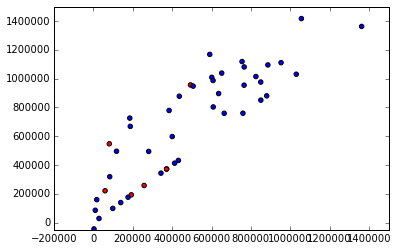

In [227]:
plt.scatter(sub[:,0],sub[:,1],c = ['b' if x == 0 else 'r' for x in labels ])
plt.ylim([-50000,1500000])
plt.xlim([-200000,1500000])

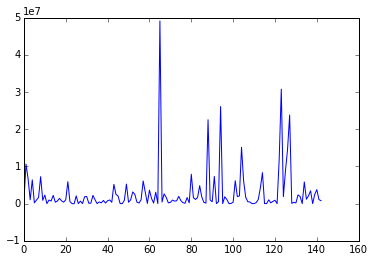

In [144]:
###Sounds about right

### Have a look at the total payments
plt.plot(selected_fit[:,1])

In [126]:
### No probs with that, cause that's just bboy Kenneth L.

In [240]:
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
from sklearn.decomposition import PCA

### Find some features to combine
print np.corrcoef(selected_fit.T)

[[ 1.          0.51131663  0.44874121  0.64871548  0.53792071  0.50994518
   0.52097669  0.38844318 -0.32926199  0.55933444]
 [ 0.51131663  1.          0.5987255   0.55953098  0.60358523  0.25357488
   0.66149858  0.96430536 -0.10345582  0.52031292]
 [ 0.44874121  0.5987255   1.          0.41581134  0.58693661  0.12486276
   0.96387438  0.56821387 -0.26806973  0.39853338]
 [ 0.64871548  0.55953098  0.41581134  1.          0.42303506  0.66433114
   0.46064575  0.4325245  -0.33098456  0.49702962]
 [ 0.53792071  0.60358523  0.58693661  0.42303506  1.          0.17998107
   0.78024846  0.58142423 -0.12564442  0.34214477]
 [ 0.50994518  0.25357488  0.12486276  0.66433114  0.17998107  1.
   0.15499602  0.13723626 -0.23574506  0.27841167]
 [ 0.52097669  0.66149858  0.96387438  0.46064575  0.78024846  0.15499602
   1.          0.63028407 -0.24423782  0.42080105]
 [ 0.38844318  0.96430536  0.56821387  0.4325245   0.58142423  0.13723626
   0.63028407  1.         -0.02518435  0.40211508]
 [-0.329

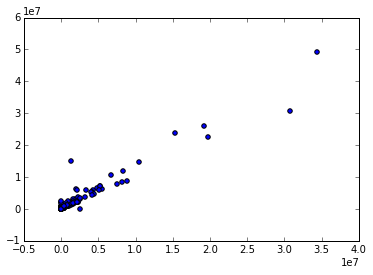

In [241]:
### Variable 3 and 7 have a correlation of 0.96, so we'll combine those
features_to_combine = selected_fit[:,[2,6]]

plt.scatter(features_to_combine[:,0],features_to_combine[:,1])

In [129]:
# Remove the two old and add the new feature to the data
pca = PCA(n_components = 1)

new_feature = pca.fit_transform(features_to_combine)
final_array = np.delete(selected_fit,[2,6],1)
final_array = np.c_[final_array,new_feature]

In [130]:
### Extract features and labels from dataset for local testing
best_feature_names.insert(0,'poi')
data = featureFormat(data_dict, best_feature_names, remove_NaN = True, remove_all_zeroes = True, sort_keys = False)
labels, features = targetFeatureSplit(data)
print best_feature_names

['poi', 'salary', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'total_stock_value', 'loan_advances', 'deferred_income', 'long_term_incentive']


In [131]:
### Task 4: Try a varity of classifiers

### Split into test and training sets
from sklearn.cross_validation import train_test_split
features_train,features_test,labels_train,labels_test = train_test_split(features,
                                          labels,
                                          test_size = 0.3,
                                          random_state = 2) 

In [132]:
### Function for trying a list of classifiers and printing certain key values
from sklearn.metrics import precision_recall_fscore_support

def standardClassifier(clf_list,features_train,features_test,labels_train,labels_test):
    for clf in clf_list:
        clf.fit(features_train,labels_train)
        precision,recall,_,_ = precision_recall_fscore_support(clf.predict(features_test),labels_test,average = 'binary')
        
        print clf
        print "Score: " ,clf.score(features_test,labels_test)
        print "Precision: ", precision
        print "Recall: ", recall
        print ""

In [133]:
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier

clf_list = [GaussianNB(),
            tree.DecisionTreeClassifier(),
            SVC(),
            AdaBoostClassifier(),
            RandomForestClassifier()]

standardClassifier(clf_list,features_train,features_test,labels_train,labels_test)

GaussianNB()
Score:  0.116279069767
Precision:  0.8
Recall:  0.0975609756098

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
Score:  0.790697674419
Precision:  0.2
Recall:  0.166666666667

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Score:  0.883720930233
Precision:  0.0
Recall:  0.0

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
Score:  0.813953488372
Precision:  0.0
Recall:  0.0

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, 

In [134]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 

### Let's explore AdaBoost because it's good

from sklearn import grid_search
from sklearn.cross_validation import StratifiedShuffleSplit

#parameters_abc={'n_estimators':[1,2,3],'learning_rate':[0.85,0.9,0.95]}
parameters_dt = {'criterion': ['gini', 'entropy'],
                 'splitter': ['random','best'],
                 'max_features': ['auto','log2',None,2,3,5,8],
                 'max_depth': [None,7,10,15],
                 'min_samples_split':[1,2,3]}

number_of_splits = 100

In [139]:
cv = StratifiedShuffleSplit(labels, number_of_splits, random_state = 16)

#abc = AdaBoostClassifier(base_estimator = RidgeClassifierCV())
#gs = grid_search.GridSearchCV(abc,parameters_abc,cv = cv, scoring = 'f1')

dt = tree.DecisionTreeClassifier()
gs = grid_search.GridSearchCV(dt,parameters_dt,cv = cv, scoring = 'precision')


gs.fit(features,labels)
print gs.best_params_

{'max_features': 8, 'min_samples_split': 1, 'criterion': 'gini', 'max_depth': 10, 'splitter': 'random'}


In [271]:
clf = gs.best_estimator_
prec = 0
rec = 0
sc = 0
for train,test in cv:
    X_train = [features[i] for i in train]
    Y_train = [labels[j] for j in train]

    X_test = [features[i] for i in test]
    Y_test = [labels[j] for j in test]

    clf.fit(X_train,Y_train)

    precision,recall,_,_ = precision_recall_fscore_support(clf.predict(X_test),Y_test,average = 'binary')
    prec = prec + precision
    rec = rec + recall
    sc = sc + clf.score(X_test,Y_test)

    
print "Score: " ,sc/number_of_splits
print "Precision: ", prec/number_of_splits
print "Recall: ", rec/number_of_splits
print ""

Score:  0.866666666667
Precision:  0.2
Recall:  0.4



In [81]:
### Pass in the data_dict with 'TOTAL' removed
my_dataset = data_dict

### The features, as selected by SelectKBest
feature_list = best_feature_names

### Dump it
dump_classifier_and_data(clf, my_dataset, feature_list)